# `SimPEG(emg3d)`

Super simple plus all possible inv-crimes (same mesh, some solver, ...).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import emg3d
import simpeg

%run ../data/sampledata
    
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib widget

## Load Simulation (incl. Survey, Models, Data)

In [3]:
sim, model = load_data("../data/Block-1src-130rec-1freq")
model_init = sim.model.copy()

sim.tol_gradient = 1e-2 # Reduce further

Data loaded from «/home/dtr/Codes/devInv/data/Block-1src-130rec-1freq.h5»
[emg3d v1.8.4.dev11+g36578d6 (format 1.0) on 2024-09-02T14:06:41.321005].


## Define active cells, instantiate Kernel and Inversion

In [4]:
# Create active cells
inds_active = np.zeros(sim.model.shape, dtype=bool)
inds_active[model.property_x < 0.1] = True            # Only target is free

inds_active = inds_active.ravel('F')

# ========> TODO move active index the mapping inside <================
active_map = simpeg.maps.InjectActiveCells(sim.model.grid, inds_active, sim.model.property_x.ravel('F')[~inds_active])
nP = int(inds_active.sum())
conductivity_map = active_map * simpeg.maps.ExpMap(nP=nP)

In [5]:
kernel = emg3d.inversion.simpeg.Kernel(
    sim,
    sigmaMap=conductivity_map,
    verbose=False,
)

## Run inversion

### TODO: Add much of this to `emg3d.inversion.simpeg`

In [6]:
em_data = simpeg.data.Data(
    kernel.survey,
    dobs=kernel.data2simpeg(sim.data.observed.data),
    standard_deviation=kernel.data2simpeg(sim.survey.standard_deviation.data),
)

m0 = sim.model.property_x.ravel('F')[inds_active] * np.log(1.)

dmis = simpeg.data_misfit.L2DataMisfit(data=em_data, simulation=kernel)

In [7]:
%%time
# TODO: Add timing to inversion.simpeg

# Define the regularization (model objective function)
reg = simpeg.regularization.WeightedLeastSquares(
    sim.model.grid,
    active_cells=inds_active,
    reference_model=m0,
    alpha_s=1e-8,
    alpha_x=1,
    alpha_y=10,
    alpha_z=1
)

nit = 5
#nit = 2
opt = simpeg.optimization.InexactGaussNewton(
    maxIter=nit, maxIterLS=nit, maxIterCG=nit, tolCG=1e-3,
)
inv_prob = simpeg.inverse_problem.BaseInvProblem(dmis, reg, opt)
starting_beta = simpeg.directives.BetaEstimate_ByEig(beta0_ratio=1)
save = simpeg.directives.SaveOutputDictEveryIteration()

beta_schedule = simpeg.directives.BetaSchedule(coolingFactor=2, coolingRate=1)
target_misfit = simpeg.directives.TargetMisfit(chifact=1)

directives_list = [
    starting_beta,
    beta_schedule,
    target_misfit,
    save
]
em_inversion = simpeg.inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
recovered_conductivity_model = em_inversion.run(m0)


Running inversion with SimPEG v0.14.3.dev3200+g2aca527a8

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Kernel problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.32e-02  1.90e+04  0.00e+00  1.90e+04    2.31e+03      0              
   1  1.16e-02  5.20e+03  2.47e+03  5.23e+03    2.07e+03      0              
   2  5.81e-03  6.60e+02  2.02e+03  6.72e+02    2.49e+02      0   Skip BFGS  
   3  2.90e-03  1.77e+02  7.22e+02  1.79e+02    1.54e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.8964e+03
0 : |xc-x_last| = 5.7064e+00 

In [8]:
# TODO: Add this to inversion.simpeg
sim.survey.data["it0"] = sim.survey.data.start
for k, v in save.outDict.items():
    sim.survey.data[f"it{v['iter']}"] = sim.survey.data.observed.copy(data=kernel.data2emg3d(save.outDict[k]['dpred']).copy())

## Plots

Depth slice: -750.0 m


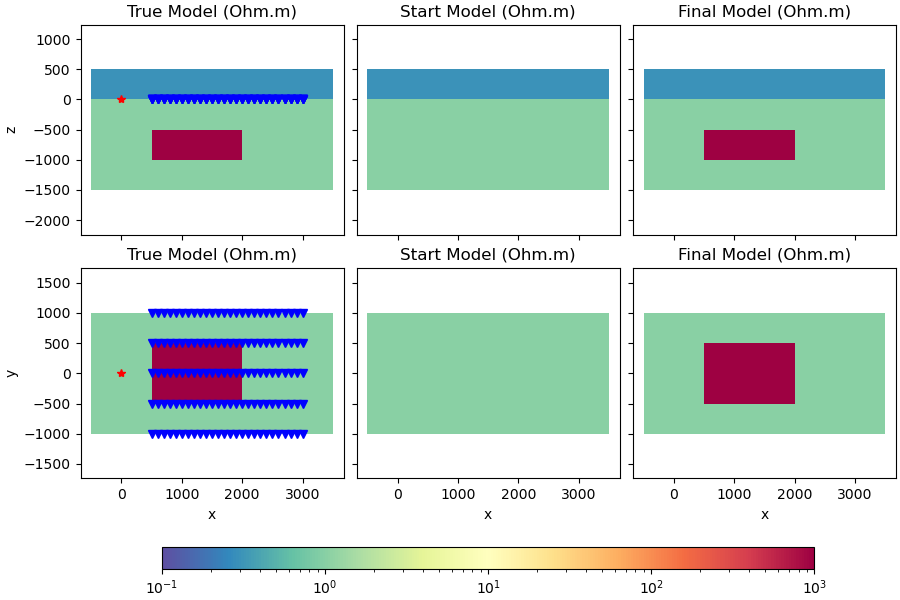

In [9]:
plot_models(sim, model_init, model)

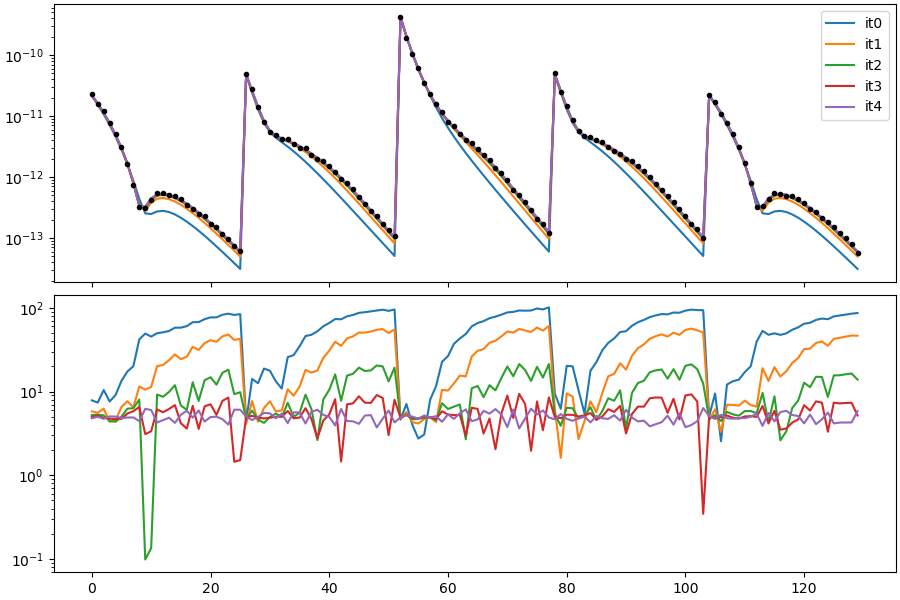

In [10]:
plot_responses(sim)

In [11]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Mon Sep 02 14:47:15 2024 CEST

                OS : Linux (Ubuntu 22.04)
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.12.5 | packaged by conda-forge | (main, Aug  8 2024, 18:36:51) [GCC
  12.4.0]

             numpy : 1.26.4
             scipy : 1.14.0
             numba : 0.60.0
             emg3d : 1.8.4.dev11+g36578d6
           empymod : 2.3.1
            xarray : 2024.7.0
        discretize : 0.10.0
              h5py : 3.11.0
        matplotlib : 3.9.1
              tqdm : 4.66.5
           IPython : 8.26.0
            simpeg : 0.14.3.dev3200+g2aca527a8
            pydiso : 0.0.5
--------------------------------------------------------------------------------